# Phase 1 — Exposure landscape

Primary lens: employee demand (tru2). Secondary check: postings (tru1) in tables only.
Occupation code used: `occu_isco_2008`.
Outputs: saved under `Results Datasets/analysis/phase1_exposure/{tables,visuals}`.


## Phase 1 configuration
- Occupation code: `occu_isco_2008`
- Primary weight: `srvy_wght_tru2` (tru1 only in concentration table)
- Thresholds: global (unweighted) p80/p90 for occupation & industry exposures (2010–2024)
- Stability filter: top 100 by Σ tru2 for scatters; top 50 for ranking tables
- Regions: explicit `Unknown` bucket with canton abbreviations


In [120]:
from pathlib import Path
import pandas as pd
import numpy as np

# Robust root finder
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for q in [cwd] + list(cwd.parents):
        candidate = q / "Results Datasets" / "final_analysis_dataset.parquet"
        if candidate.exists():
            return q
    return cwd

ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"
OUT_ROOT = ROOT / "Results Datasets" / "analysis" / "phase1_exposure"
OUT_TABLES = OUT_ROOT / "tables"
OUT_VIS = OUT_ROOT / "visuals"
for d in [OUT_ROOT, OUT_TABLES, OUT_VIS]:
    d.mkdir(parents=True, exist_ok=True)

# Load and filter
df = pd.read_parquet(DATA_PATH)
df = df[(df["adve_time_year"] >= 2010) & (df["adve_time_year"] <= 2024)].copy()

# Dtypes
df["adve_time_year"] = df["adve_time_year"].astype("int64")
df["ai_requirement"] = df["ai_requirement"].astype("string")

# Region labels with Unknown bucket and canton abbreviations
canton_map = {
    1:"ZH",2:"BE",3:"LU",4:"UR",5:"SZ",6:"OW",7:"NW",8:"GL",9:"ZG",
    10:"FR",11:"SO",12:"BS",13:"BL",14:"SH",15:"AR",16:"AI",17:"SG",
    18:"GR",19:"AG",20:"TG",21:"TI",22:"VD",23:"VS",24:"NE",25:"GE",26:"JU"
}
special_codes = {"-3","-7","-8","-9"}

for col in ["loca_regi_kant", "loca_regi_nuts"]:
    raw = df[col].astype('string') if col in df.columns else pd.Series([pd.NA]*len(df), dtype='string')
    label = raw.where(~raw.isin(special_codes), other="Unknown")
    label = label.fillna("Unknown")
    if col == "loca_regi_kant":
        def map_canton(val):
            if val == "Unknown" or pd.isna(val):
                return "Unknown"
            return canton_map.get(int(val), val) if str(val).isdigit() else val
        label = label.apply(map_canton)
    df[f"{col}_label"] = label.astype('string')

occ_exp_col = "occupation_exposure"
ind_exp_col = "industry_exposure_weighted"
occ_code = "occu_isco_2008"

print(df.shape)


(59794, 99)


In [121]:
# Global thresholds (unweighted) for exposure
occ_thresh = df[occ_exp_col].quantile([0.8, 0.9]).to_dict()
ind_thresh = df[ind_exp_col].quantile([0.8, 0.9]).to_dict()
thresholds = pd.DataFrame({
    "measure": ["occupation", "industry"],
    "p80": [occ_thresh.get(0.8), ind_thresh.get(0.8)],
    "p90": [occ_thresh.get(0.9), ind_thresh.get(0.9)],
})
thresholds.to_csv(OUT_TABLES / "table_phase1_thresholds.csv", index=False)
thresholds


,measure,p80,p90
0,occupation,1.238368,1.284863
1,industry,-0.111504,0.029032


In [122]:
rows = []
for year, g in df.groupby("adve_time_year"):
    total_w = g["srvy_wght_tru2"].sum()
    row = {"year": int(year)}
    for col in [occ_exp_col, ind_exp_col]:
        miss = g[col].isna()
        row[f"{col}_miss_pct"] = miss.mean() * 100
        row[f"{col}_miss_tru2_share"] = g.loc[miss, "srvy_wght_tru2"].sum() / total_w if total_w > 0 else 0
    rows.append(row)
coverage_year = pd.DataFrame(rows).sort_values("year")
coverage_year.to_csv(OUT_TABLES / "coverage_by_year.csv", index=False)
coverage_year.head()


,year,occupation_exposure_miss_pct,occupation_exposure_miss_tru2_share,industry_exposure_weighted_miss_pct,industry_exposure_weighted_miss_tru2_share
0,2010,6.266830,0.058251,20.171359,0.153547
1,2011,7.216004,0.055885,17.623244,0.148957
2,2012,8.492120,0.092880,14.231945,0.114610
3,2013,8.750000,0.088287,15.000000,0.131913
4,2014,9.344529,0.085730,15.763814,0.148622


In [123]:
p80_occ = thresholds.loc[thresholds.measure=="occupation", "p80"].iloc[0]
p90_occ = thresholds.loc[thresholds.measure=="occupation", "p90"].iloc[0]
p80_ind = thresholds.loc[thresholds.measure=="industry", "p80"].iloc[0]
p90_ind = thresholds.loc[thresholds.measure=="industry", "p90"].iloc[0]
unknown_share = df[df['loca_regi_kant_label']=="Unknown"]["srvy_wght_tru2"].sum() / df["srvy_wght_tru2"].sum()
coverage_minmax = coverage_year[[f"{occ_exp_col}_miss_pct", f"{ind_exp_col}_miss_pct"]].agg(['min','max'])
print('Thresholds:', {'occ_p80':p80_occ,'occ_p90':p90_occ,'ind_p80':p80_ind,'ind_p90':p90_ind})
print('Unknown region share (tru2):', unknown_share)
print('Coverage miss pct min/max (occ, ind):')
print(coverage_minmax)


Thresholds: {'occ_p80': 1.2383682999999999, 'occ_p90': 1.284863, 'ind_p80': -0.11150409999999998, 'ind_p90': 0.02903156181818183}
Unknown region share (tru2): 0.060835489601052714
Coverage miss pct min/max (occ, ind):
     occupation_exposure_miss_pct  industry_exposure_weighted_miss_pct
min                      6.188119                            14.231945
max                     11.449353                            20.171359


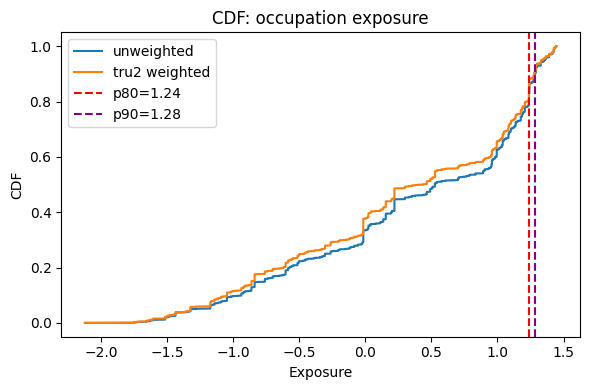

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_cdf_occ.png


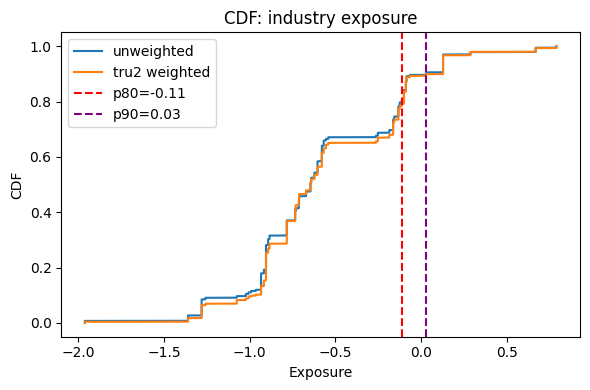

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_cdf_ind.png


In [124]:
import matplotlib.pyplot as plt

p80_occ = thresholds.loc[thresholds.measure=="occupation", "p80"].iloc[0]
p90_occ = thresholds.loc[thresholds.measure=="occupation", "p90"].iloc[0]
p80_ind = thresholds.loc[thresholds.measure=="industry", "p80"].iloc[0]
p90_ind = thresholds.loc[thresholds.measure=="industry", "p90"].iloc[0]

def plot_cdf(series, weights=None, label="weighted", ax=None):
    s = series.dropna().to_numpy()
    if weights is None:
        w = np.ones_like(s)
    else:
        w = weights.loc[series.dropna().index].to_numpy()
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cum = np.cumsum(w_sorted)
    cum = cum / cum[-1]
    ax.plot(s_sorted, cum, label=label)

# Occupation CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(df[occ_exp_col], None, label="unweighted", ax=ax)
plot_cdf(df[occ_exp_col], df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(p80_occ, color='red', linestyle='--', label=f'p80={p80_occ:.2f}')
ax.axvline(p90_occ, color='purple', linestyle='--', label=f'p90={p90_occ:.2f}')
ax.set_title("CDF: occupation exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_phase1_cdf_occ.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

# Industry CDF
fig, ax = plt.subplots(figsize=(6,4))
plot_cdf(df[ind_exp_col], None, label="unweighted", ax=ax)
plot_cdf(df[ind_exp_col], df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.axvline(p80_ind, color='red', linestyle='--', label=f'p80={p80_ind:.2f}')
ax.axvline(p90_ind, color='purple', linestyle='--', label=f'p90={p90_ind:.2f}')
ax.set_title("CDF: industry exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "fig_phase1_cdf_ind.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


In [125]:
def demand_share_at_threshold(col, thresh, weight_col):
    mask = df[col] >= thresh
    return df.loc[mask, weight_col].sum() / df[weight_col].sum()

coverage_occ = df[occ_exp_col].notna().mean()
coverage_ind = df[ind_exp_col].notna().mean()

data_rows = []
for col, label in [(occ_exp_col, "occupation"), (ind_exp_col, "industry")]:
    p80, p90 = thresholds.loc[thresholds.measure==label, ["p80","p90"]].values[0]
    row = {"measure": label, "coverage_tru2": df[col].notna().mean()}
    row["p80"] = p80
    row["p90"] = p90
    row["share_top20_tru2"] = demand_share_at_threshold(col, p80, "srvy_wght_tru2")
    row["share_top10_tru2"] = demand_share_at_threshold(col, p90, "srvy_wght_tru2")
    row["share_bottom10_tru2"] = df.loc[df[col] <= df[col].quantile(0.1), "srvy_wght_tru2"].sum() / df["srvy_wght_tru2"].sum()
    row["share_top20_tru1"] = demand_share_at_threshold(col, p80, "srvy_wght_tru1")
    row["share_top10_tru1"] = demand_share_at_threshold(col, p90, "srvy_wght_tru1")
    row["share_bottom10_tru1"] = df.loc[df[col] <= df[col].quantile(0.1), "srvy_wght_tru1"].sum() / df["srvy_wght_tru1"].sum()
    data_rows.append(row)
concentration_tbl = pd.DataFrame(data_rows)
concentration_tbl.to_csv(OUT_TABLES / "table_phase1_concentration_summary.csv", index=False)
concentration_tbl


,measure,coverage_tru2,p80,p90,share_top20_tru2,share_top10_tru2,share_bottom10_tru2,share_top20_tru1,share_top10_tru1,share_bottom10_tru1
0,occupation,0.915527,1.238368,1.284863,0.178464,0.083495,0.115617,0.183060,0.086137,0.109339
1,industry,0.839047,-0.111504,0.029032,0.186818,0.092769,0.075992,0.178375,0.087949,0.076919


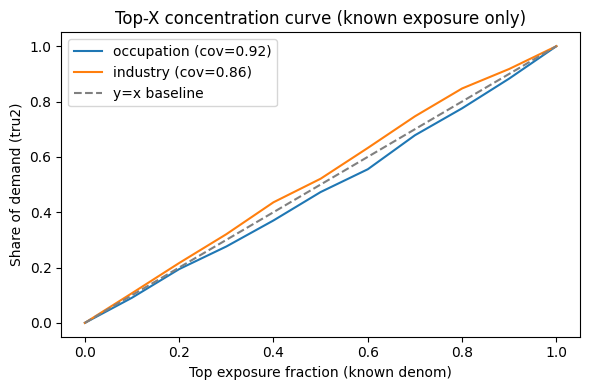

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_topx_curve.png


,top_fraction,occ_share,ind_share
0,0.0,0.000000,0.000000
1,0.1,0.090915,0.107437
2,0.2,0.194322,0.216356
3,0.3,0.276060,0.320481
4,0.4,0.370185,0.435852
5,0.5,0.472856,0.521040
6,0.6,0.555198,0.632176
7,0.7,0.678099,0.746539
8,0.8,0.775447,0.847140
9,0.9,0.883051,0.917694


In [126]:
import matplotlib.pyplot as plt

# restrict to non-missing exposure for known-denom curve
occ_nonmiss = df[df[occ_exp_col].notna()].copy()
ind_nonmiss = df[df[ind_exp_col].notna()].copy()
occ_total = occ_nonmiss['srvy_wght_tru2'].sum()
ind_total = ind_nonmiss['srvy_wght_tru2'].sum()
xs = np.linspace(0, 1, 11)

def topx_share_nonmiss(sub_df, col, frac, total):
    if frac <= 0 or total == 0:
        return 0.0
    s = pd.to_numeric(sub_df[col], errors='coerce').to_numpy(dtype=float)
    w = sub_df['srvy_wght_tru2'].to_numpy(dtype=float)
    valid = ~np.isnan(s)
    s = s[valid]
    w = w[valid]
    if len(s) == 0:
        return np.nan
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cutoff = np.nanquantile(s_sorted, 1 - frac)
    mask = s_sorted >= cutoff
    return w_sorted[mask].sum() / w_sorted.sum()

rows = []
for x in xs:
    rows.append({
        'top_fraction': x,
        'occ_share': topx_share_nonmiss(occ_nonmiss, occ_exp_col, x, occ_total),
        'ind_share': topx_share_nonmiss(ind_nonmiss, ind_exp_col, x, ind_total),
    })
conc_curve = pd.DataFrame(rows)

cov_occ = occ_total / df['srvy_wght_tru2'].sum()
cov_ind = ind_total / df['srvy_wght_tru2'].sum()

plt.figure(figsize=(6,4))
plt.plot(conc_curve['top_fraction'], conc_curve['occ_share'], label=f'occupation (cov={cov_occ:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['ind_share'], label=f'industry (cov={cov_ind:.2f})')
plt.plot(conc_curve['top_fraction'], conc_curve['top_fraction'], linestyle='--', color='gray', label='y=x baseline')
plt.xlabel('Top exposure fraction (known denom)')
plt.ylabel('Share of demand (tru2)')
plt.title('Top-X concentration curve (known exposure only)')
plt.legend()
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_topx_curve.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)
conc_curve


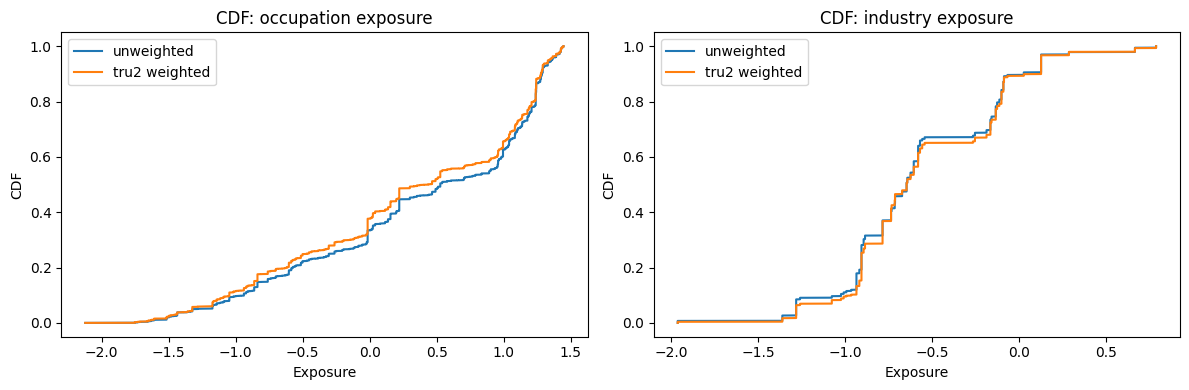

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/cdf_exposures.png


In [127]:
import matplotlib.pyplot as plt

def plot_cdf(series, weights=None, label="weighted", ax=None):
    s = series.dropna().to_numpy()
    if weights is None:
        w = np.ones_like(s)
    else:
        w = weights.loc[series.dropna().index].to_numpy()
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cum = np.cumsum(w_sorted)
    cum = cum / cum[-1]
    ax.plot(s_sorted, cum, label=label)

fig, axes = plt.subplots(1,2, figsize=(12,4))
# Occupation
ax = axes[0]
plot_cdf(df[occ_exp_col], None, label="unweighted", ax=ax)
plot_cdf(df[occ_exp_col], df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.set_title("CDF: occupation exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
# Industry
ax = axes[1]
plot_cdf(df[ind_exp_col], None, label="unweighted", ax=ax)
plot_cdf(df[ind_exp_col], df["srvy_wght_tru2"], label="tru2 weighted", ax=ax)
ax.set_title("CDF: industry exposure")
ax.set_xlabel("Exposure")
ax.set_ylabel("CDF")
ax.legend()
plt.tight_layout()
fig_path = OUT_VIS / "cdf_exposures.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/3339145085.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  occ_mean_exp = occ_group.apply(lambda g: np.average(g[occ_exp_col], weights=g['srvy_wght_tru2']) if g[occ_exp_col].notna().any() else np.nan)


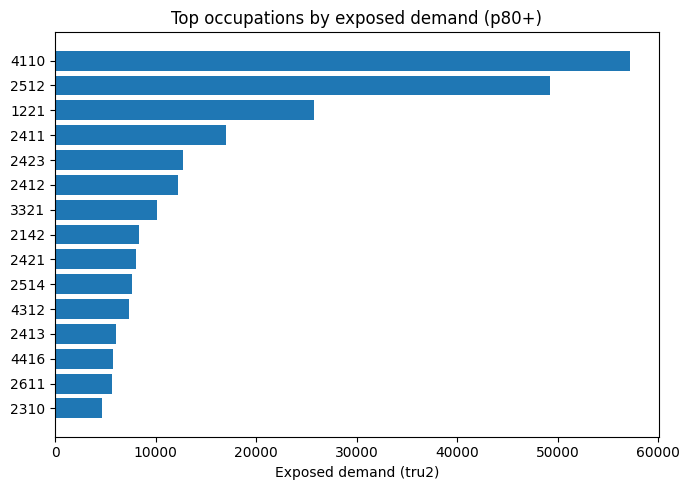

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_occ_top15_bar.png


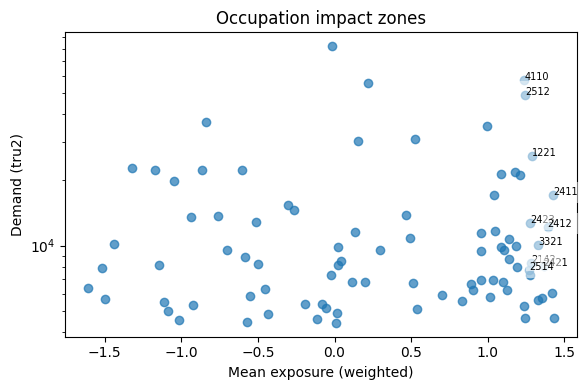

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_occ_scatter.png


In [128]:
# Occupations impact zones with stability filter
p80_occ = thresholds.loc[thresholds.measure=="occupation", "p80"].iloc[0]
mask_high = df[occ_exp_col] >= p80_occ
occ_group = df.groupby(occ_code)

# Stability filter: keep top 100 by demand for scatter, top 50 for tables
occ_metrics = occ_group[['srvy_wght_tru2','srvy_wght_tru1']].sum().rename(columns={'srvy_wght_tru2':'demand_tru2','srvy_wght_tru1':'postings_tru1'})
# weighted mean
occ_mean_exp = occ_group.apply(lambda g: np.average(g[occ_exp_col], weights=g['srvy_wght_tru2']) if g[occ_exp_col].notna().any() else np.nan)
occ_metrics['mean_exp'] = occ_mean_exp
high_demand = df.loc[mask_high].groupby(occ_code)['srvy_wght_tru2'].sum().rename('high_exp_demand')
occ_metrics = occ_metrics.join(high_demand, how='left').fillna({'high_exp_demand':0})
occ_metrics['high_exp_share'] = occ_metrics['high_exp_demand'] / occ_metrics['demand_tru2']
occ_metrics['impact_score'] = occ_metrics['demand_tru2'] * occ_metrics['mean_exp']
occ_metrics = occ_metrics.reset_index()
occ_metrics['n_ads'] = occ_group.size().values

occ_scatter = occ_metrics.nlargest(100, 'demand_tru2')
occ_top_exposed = occ_metrics.nlargest(50, 'high_exp_demand')
occ_top_impact = occ_metrics.nlargest(50, 'impact_score')
occ_top_exposed.to_csv(OUT_TABLES / 'table_phase1_occ_top25_exposed.csv', index=False)
occ_top_impact.to_csv(OUT_TABLES / 'table_phase1_occ_top25_impact.csv', index=False)
occ_top_exposed.head(25), occ_top_impact.head(25)

# Bar chart top 15 by exposed demand
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
bar_data = occ_top_exposed.nlargest(15, 'high_exp_demand')
plt.barh(bar_data[occ_code].astype(str), bar_data['high_exp_demand'])
plt.gca().invert_yaxis()
plt.xlabel('Exposed demand (tru2)')
plt.title('Top occupations by exposed demand (p80+)')
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_occ_top15_bar.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

# Scatter
plt.figure(figsize=(6,4))
plt.scatter(occ_scatter['mean_exp'], occ_scatter['demand_tru2'], alpha=0.7)
for _, row in occ_scatter.nlargest(10, 'high_exp_demand').iterrows():
    plt.text(row['mean_exp'], row['demand_tru2'], str(row[occ_code])[:6], fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
plt.xlabel('Mean exposure (weighted)')
plt.ylabel('Demand (tru2)')
plt.yscale('log')
plt.title('Occupation impact zones')
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_occ_scatter.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/1867482760.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ind_mean_exp = ind_group.apply(lambda g: np.average(g[ind_exp_col], weights=g['srvy_wght_tru2']) if g[ind_exp_col].notna().any() else np.nan)


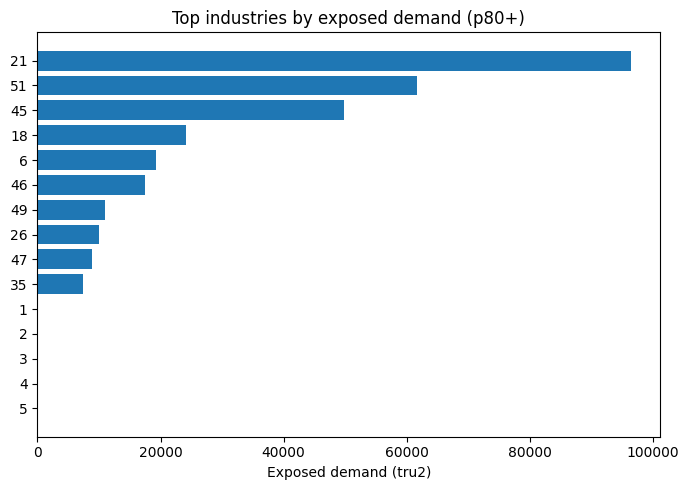

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_ind_top15_bar.png


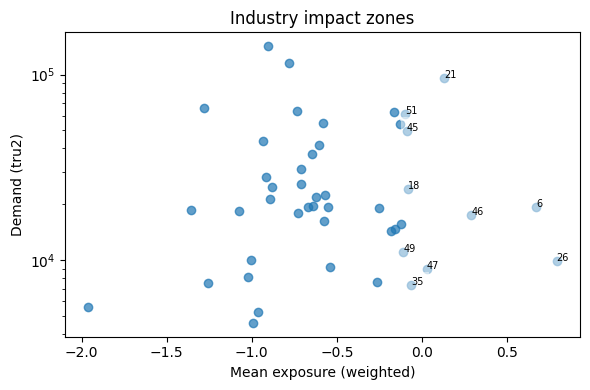

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_ind_scatter.png


In [129]:
# Industries impact zones with stability filter
p80_ind = thresholds.loc[thresholds.measure=="industry", "p80"].iloc[0]
mask_high_ind = df[ind_exp_col] >= p80_ind
ind_group = df.groupby('comp_indu_noga')
ind_metrics = ind_group[['srvy_wght_tru2','srvy_wght_tru1']].sum().rename(columns={'srvy_wght_tru2':'demand_tru2','srvy_wght_tru1':'postings_tru1'})
ind_mean_exp = ind_group.apply(lambda g: np.average(g[ind_exp_col], weights=g['srvy_wght_tru2']) if g[ind_exp_col].notna().any() else np.nan)
ind_metrics['mean_exp'] = ind_mean_exp
high_demand_ind = df.loc[mask_high_ind].groupby('comp_indu_noga')['srvy_wght_tru2'].sum().rename('high_exp_demand')
ind_metrics = ind_metrics.join(high_demand_ind, how='left').fillna({'high_exp_demand':0})
ind_metrics['high_exp_share'] = ind_metrics['high_exp_demand'] / ind_metrics['demand_tru2']
ind_metrics['impact_score'] = ind_metrics['demand_tru2'] * ind_metrics['mean_exp']
ind_metrics = ind_metrics.reset_index()
ind_metrics['n_ads'] = ind_group.size().values

ind_scatter = ind_metrics.nlargest(100, 'demand_tru2')
ind_top_exposed = ind_metrics.nlargest(50, 'high_exp_demand')
ind_top_impact = ind_metrics.nlargest(50, 'impact_score')
ind_top_exposed.to_csv(OUT_TABLES / 'table_phase1_ind_top25_exposed.csv', index=False)
ind_top_impact.to_csv(OUT_TABLES / 'table_phase1_ind_top25_impact.csv', index=False)
ind_top_exposed.head(25), ind_top_impact.head(25)

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
bar_data = ind_top_exposed.nlargest(15, 'high_exp_demand')
plt.barh(bar_data['comp_indu_noga'].astype(str), bar_data['high_exp_demand'])
plt.gca().invert_yaxis()
plt.xlabel('Exposed demand (tru2)')
plt.title('Top industries by exposed demand (p80+)')
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_ind_top15_bar.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

plt.figure(figsize=(6,4))
plt.scatter(ind_scatter['mean_exp'], ind_scatter['demand_tru2'], alpha=0.7)
for _, row in ind_scatter.nlargest(10, 'high_exp_demand').iterrows():
    plt.text(row['mean_exp'], row['demand_tru2'], str(row['comp_indu_noga']), fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
plt.xlabel('Mean exposure (weighted)')
plt.ylabel('Demand (tru2)')
plt.yscale('log')
plt.title('Industry impact zones')
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_ind_scatter.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)


/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/421459277.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reg_metrics['mean_exp'] = reg_group.apply(weighted_mean_region)
/var/folders/b8/xcnlw57x6_3gqylzftwx02tr0000gn/T/ipykernel_33852/421459277.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].su

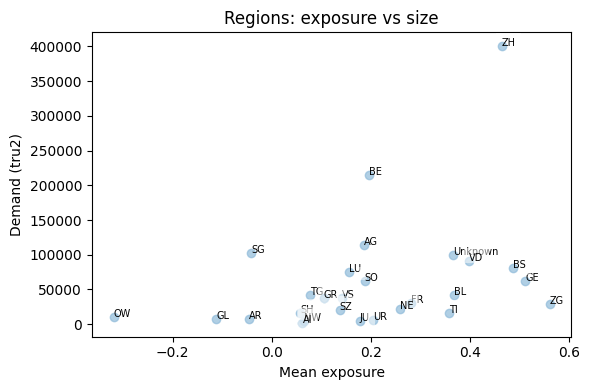

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_region_scatter.png


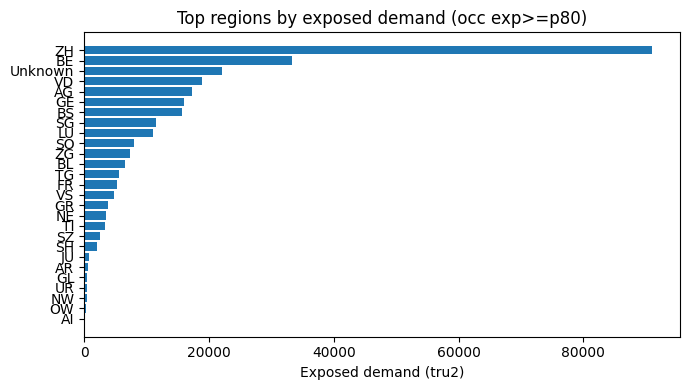

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_region_top15_bar.png


In [133]:
region_col = "loca_regi_kant_label"
p80_occ = thresholds.loc[thresholds.measure=="occupation", "p80"].iloc[0]
mask_high = df[occ_exp_col] >= p80_occ
reg_group = df.groupby(region_col)

def weighted_mean_region(g):
    x = g.loc[g[occ_exp_col].notna(), occ_exp_col]
    w = g.loc[g[occ_exp_col].notna(), 'srvy_wght_tru2']
    return np.average(x, weights=w) if len(x) else np.nan

reg_metrics = reg_group[['srvy_wght_tru2','srvy_wght_tru1']].sum().rename(columns={'srvy_wght_tru2':'demand_tru2','srvy_wght_tru1':'postings_tru1'})
reg_metrics['mean_exp'] = reg_group.apply(weighted_mean_region)

high_demand_reg = df.loc[mask_high].groupby(region_col)["srvy_wght_tru2"].sum().rename("high_exp_demand")
reg_metrics = reg_metrics.join(high_demand_reg, how="left")
reg_metrics["high_exp_demand"] = reg_metrics["high_exp_demand"].fillna(0)
reg_metrics["high_exp_share_total"] = reg_metrics["high_exp_demand"] / reg_metrics["demand_tru2"]
known_denom = reg_group.apply(lambda g: g.loc[g[occ_exp_col].notna(), "srvy_wght_tru2"].sum())
reg_metrics["high_exp_share_known"] = reg_metrics["high_exp_demand"] / known_denom
reg_metrics["coverage_share"] = reg_metrics.index.map(lambda r: reg_group.get_group(r)[occ_exp_col].notna().mean() if r in reg_group.groups else np.nan)
reg_metrics.to_csv(OUT_TABLES / "table_phase1_region_summary.csv", index=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.scatter(reg_metrics["mean_exp"], reg_metrics["demand_tru2"], alpha=0.7)
labels = reg_metrics.nlargest(50, "high_exp_demand")
for _, row in labels.iterrows():
    plt.text(row["mean_exp"], row["demand_tru2"], str(row.name), fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
plt.xlabel("Mean exposure")
plt.ylabel("Demand (tru2)")
#plt.yscale('log')
plt.title("Regions: exposure vs size")
plt.tight_layout()
fig_path = OUT_VIS / "fig_phase1_region_scatter.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)

plt.figure(figsize=(7,4))
top_reg = reg_metrics.nlargest(50, "high_exp_demand")
plt.barh(top_reg.index.astype(str), top_reg["high_exp_demand"])
plt.gca().invert_yaxis()
plt.xlabel("Exposed demand (tru2)")
plt.title("Top regions by exposed demand (occ exp>=p80)")
plt.tight_layout()
fig_path = OUT_VIS / "fig_phase1_region_top15_bar.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved", fig_path)


In [131]:
# Region decomposition: top regions by exposed demand (tidy tables)
p80_occ = thresholds.loc[thresholds.measure=="occupation", "p80"].iloc[0]
region_col = "loca_regi_kant_label"
mask_high = df[occ_exp_col] >= p80_occ
reg_high = df.loc[mask_high]

# top 5 regions by exposed demand
reg_metrics = reg_metrics.sort_values("high_exp_demand", ascending=False)
top_regions = reg_metrics.head(5).index.tolist()

rows_occ = []
rows_ind = []
for reg in top_regions:
    sub = reg_high[reg_high[region_col] == reg]
    top_occ = sub.groupby(occ_code)["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    top_ind = sub.groupby("comp_indu_noga")["srvy_wght_tru2"].sum().sort_values(ascending=False).head(5)
    for rank, (code, val) in enumerate(top_occ.items(), start=1):
        rows_occ.append({"region": reg, "rank": rank, "occ_code": code, "exposed_demand_tru2": val})
    for rank, (code, val) in enumerate(top_ind.items(), start=1):
        rows_ind.append({"region": reg, "rank": rank, "indu_code": code, "exposed_demand_tru2": val})

occ_long = pd.DataFrame(rows_occ)
ind_long = pd.DataFrame(rows_ind)
occ_long.to_csv(OUT_TABLES / "table_phase1_region_top_occ_contrib_long.csv", index=False)
ind_long.to_csv(OUT_TABLES / "table_phase1_region_top_ind_contrib_long.csv", index=False)
occ_long, ind_long


(     region  rank  occ_code  exposed_demand_tru2
 0        ZH     1      2512           14520.1474
 1        ZH     2      4110           12301.2931
 2        ZH     3      1221            7268.6524
 3        ZH     4      2411            5591.5524
 4        ZH     5      2412            4265.3955
 5        BE     1      4110            6863.5182
 6        BE     2      2512            6233.1799
 7        BE     3      1221            2854.4018
 8        BE     4      2142            2292.3923
 9        BE     5      2423            1771.7726
 10  Unknown     1      2512            5132.0282
 11  Unknown     2      1221            3129.6089
 12  Unknown     3      4110            3074.0045
 13  Unknown     4      2411            2198.1420
 14  Unknown     5      2423             938.9115
 15       VD     1      4110            3859.6203
 16       VD     2      2512            2912.6425
 17       VD     3      1221            1604.7048
 18       VD     4      2423            1286.4785


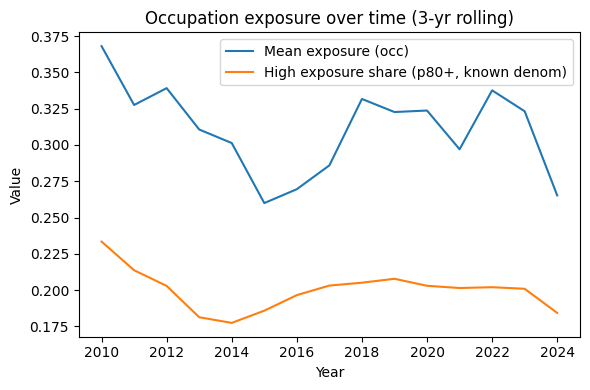

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_trend_occ.png


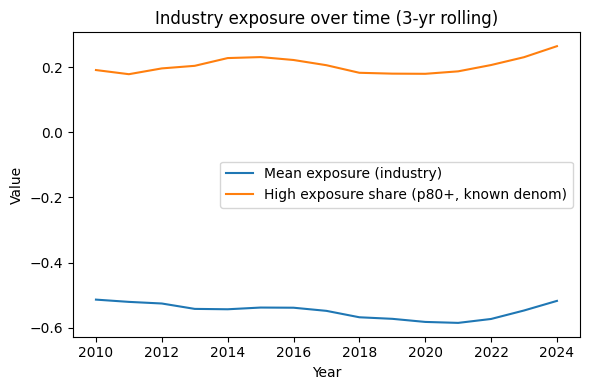

Saved /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1_exposure/visuals/fig_phase1_trend_ind.png


,year,occ_mean_exp,ind_mean_exp,occ_high_share_known,ind_high_share_known
0,2010,0.368069,-0.513463,0.233460,0.190676
1,2011,0.327557,-0.520405,0.213720,0.177948
2,2012,0.339150,-0.525382,0.202929,0.195724
3,2013,0.310677,-0.541916,0.181340,0.203624
4,2014,0.301336,-0.543070,0.177456,0.227403


In [132]:
# Exposure mix over time (annual + 3-year rolling)
p80_occ = thresholds.loc[thresholds.measure=="occupation", "p80"].iloc[0]
p80_ind = thresholds.loc[thresholds.measure=="industry", "p80"].iloc[0]
rows = []
for yr, g in df.groupby('adve_time_year'):
    tot_tru2 = g['srvy_wght_tru2'].sum()
    occ_known = g[occ_exp_col].notna()
    ind_known = g[ind_exp_col].notna()
    occ_mean = np.average(g.loc[occ_known, occ_exp_col], weights=g.loc[occ_known, 'srvy_wght_tru2']) if occ_known.any() else np.nan
    ind_mean = np.average(g.loc[ind_known, ind_exp_col], weights=g.loc[ind_known, 'srvy_wght_tru2']) if ind_known.any() else np.nan
    row = {
        'year': int(yr),
        'occ_mean_exp': occ_mean,
        'ind_mean_exp': ind_mean,
        'occ_high_share_known': g.loc[occ_known & (g[occ_exp_col] >= p80_occ), 'srvy_wght_tru2'].sum() / g.loc[occ_known, 'srvy_wght_tru2'].sum() if occ_known.any() else np.nan,
        'ind_high_share_known': g.loc[ind_known & (g[ind_exp_col] >= p80_ind), 'srvy_wght_tru2'].sum() / g.loc[ind_known, 'srvy_wght_tru2'].sum() if ind_known.any() else np.nan,
    }
    rows.append(row)
trend_annual = pd.DataFrame(rows).sort_values('year')
trend_annual.to_csv(OUT_TABLES / 'table_phase1_trends_annual.csv', index=False)

# 3-year rolling
trend_roll = trend_annual.set_index('year').rolling(window=3, min_periods=1).mean().reset_index()
trend_roll.to_csv(OUT_TABLES / 'table_phase1_trends_binned_or_rolling.csv', index=False)

import matplotlib.pyplot as plt
# occupation plot
plt.figure(figsize=(6,4))
plt.plot(trend_roll['year'], trend_roll['occ_mean_exp'], label='Mean exposure (occ)')
plt.plot(trend_roll['year'], trend_roll['occ_high_share_known'], label='High exposure share (p80+, known denom)')
plt.title('Occupation exposure over time (3-yr rolling)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_trend_occ.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)

plt.figure(figsize=(6,4))
plt.plot(trend_roll['year'], trend_roll['ind_mean_exp'], label='Mean exposure (industry)')
plt.plot(trend_roll['year'], trend_roll['ind_high_share_known'], label='High exposure share (p80+, known denom)')
plt.title('Industry exposure over time (3-yr rolling)')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
fig_path = OUT_VIS / 'fig_phase1_trend_ind.png'
plt.savefig(fig_path, dpi=150)
plt.show()
print('Saved', fig_path)
trend_roll.head()
